# Setup

In [141]:
import warnings
warnings.simplefilter("ignore")

In [142]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.14.0
  import geopandas as gpd
  if gpd.__version__ != "0.14.0":
    !pip install -U geopandas==0.10.0

---

# Exercise
1. load the shapefile of ISTAT with the information of the provinces
- filter it for the province on Bolzano
- plot it
2. load the shapefile of ISTAT with the informations of the muncipalities
- identify the cities of the province selected with the biggest and smallest area
- extract all the centroids of the areas expressed in WGS84
- extract a representative point for the area of each municipality converted in WGS84
- save the points in a GeoJSON file
- calculate the distance on the geodentic between the municipality with the big area and smallest area by using the centroid
3. download the shapefile of the [Mountain Basins Station](hhttps://media.githubusercontent.com/media/napo/geospatial_datascience_unitn_2023/main/data/idrspacq.zip) of Trentino - projection ETRS89 UTM32N
- plot the geometries where CODE is "0191" for the table "d_tipouso.dbf"
- convert in WGS84 and create a KML and plot it on a website

---

# Solutions

## learning objectives
* repeat the concepts on the previous lesson
* introduce geopackage
* centroid vs representative point

--- 

### Import of the packages

In [143]:
import geopandas as gpd
import pandas as pd
import os
import urllib
from matplotlib import pyplot as plt  #to avoid the warning message by plotting the geometries

## 1. load the shapefile of ISTAT with the information of the provinces

### This request is replaced with the use of geopackage

In the course material a geopackage file is available with all the shapefiles of the administrative limits of ISTAT (2023) with generalized geometries

[download](https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/istat_administrative_units_2023.gpkg) the file *istat_administrative_units_2023.gpkg* from the repository from 
directory "data"

In [144]:
url = 'https://github.com/napo/geospatial_datascience_unitn_2023/raw/main/data/istat/istat_administrative_units_2023.gpkg'

In [145]:
urllib.request.urlretrieve(url ,"istat_administrative_units_2023.gpkg")

('istat_administrative_units_2023.gpkg',
 <http.client.HTTPMessage at 0x7fb730216910>)

### Geopackage
![](https://www.ogc.org/pub/www/files/blog/Geopackage_layers.png)

[GeoPackage](http://opengeospatial.github.io/e-learning/geopackage/text/basic-index.html) is used for storing and accessing:
* Vector feature data
* Imagery tile matrix sets
* Raster map tile matrix sets
* non-spatial tabular data
* Metadata that describes other stored data

To have a look at the structure of the files, download the files and open them using the basic SQLite3 command-line utility.

```
sqlite3 istat_administrative_units_2023.gpkg
```
```
SQLite version 3.37.2 2022-01-06 13:25:41
Enter ".help" for usage hints.
sqlite>.table
```
```
gpkg_contents                     rtree_macroregions_geom_parent  
gpkg_extensions                   rtree_macroregions_geom_rowid   
gpkg_geometry_columns             rtree_municipalities_geom       
gpkg_metadata                     rtree_municipalities_geom_node  
gpkg_metadata_reference           rtree_municipalities_geom_parent
gpkg_ogr_contents                 rtree_municipalities_geom_rowid 
gpkg_spatial_ref_sys              rtree_provincies_geom           
gpkg_tile_matrix                  rtree_provincies_geom_node      
gpkg_tile_matrix_set              rtree_provincies_geom_parent    
macroregions                      rtree_provincies_geom_rowid     
municipalities                    rtree_regions_geom              
provincies                        rtree_regions_geom_node         
regions                           rtree_regions_geom_parent       
rtree_macroregions_geom           rtree_regions_geom_rowid        
rtree_macroregions_geom_node     
```
```
sqlite> .header on
```


```
sqlite> select * from macroregions;
```
```
fid|geom|COD_RIP|DEN_RIP|Shape_Leng|Shape_Area
1|GP|1|Nord-Ovest|2330182.61891|57929577720.9
2|GP|2|Nord-Est|2327764.9178|62385087837.3
3|GP|3|Centro|2010203.10916|58018645204.4
4|GP|4|Sud|2517096.68356|73777950167.2
5|GP|5|Isole|2775538.337|49917777679.9
```
```
sqlite> .q
```

Geopandas can manage geopackage by using [fiona](https://github.com/Toblerity/Fiona)

In [146]:
import fiona

In [147]:
fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r',
 'KML': 'rw'}

```
'GPKG': 'raw',
```
**raw** => **r**ead **a**ppend **w**rite

geopandas can:
* **r**ead *geopackage* files
* **a**append data to a *geopackage* file
* **w**rite data to a *geopackage* file

geopackage can store more layers, so we have to investigate the contents

In [148]:
fiona.listlayers('istat_administrative_units_2023.gpkg')

['municipalities', 'provinces', 'regions', 'macroregions']

In [149]:
provinces = gpd.read_file("istat_administrative_units_2023.gpkg",layer="provinces")

*TIP*: you can also download the file directly from geopandas with this function

In [150]:
provinces = gpd.read_file(url,layer="provinces")

In [151]:
provinces.head(3)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,Citta metropolitana,"MULTIPOLYGON (((411015.006 5049970.983, 411266..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,"MULTIPOLYGON (((438328.612 5087208.215, 439028..."
2,1,1,3,0,3,Novara,-,Novara,NO,Provincia,"MULTIPOLYGON (((460929.542 5076320.298, 461165..."


In [152]:
provinces.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'DEN_PROV',
       'DEN_CM', 'DEN_UTS', 'SIGLA', 'TIPO_UTS', 'geometry'],
      dtype='object')

**COD_RIP**<br/>
*codice ripartizione*<br/>
numeric code of the macroregion of belonging

**COD_REG**<br/>
*codice regione*<br/>
numeric code of the region of belonging

**COD_PROV**<br/>
*codice provincia*<br/>
numeric code of the region of belonging

**COD_CM**<br/>
*codice comune*<br/>
Istat code of the metropolitan city (three characters in
reference to all official statistics are
numeric format) obtained by adding the value 200 to
adopted the statistical codes of the cities
corresponding code of the province.

**COD_UTS**<br/>
*codice unità territoriali sovracomunali*<br/>
Numeric code that uniquely identifies the Units
territorial supra-municipal on the national territory.

**DEN_PROV**<br/>
*denominazione provincia*<br/>
name of the province

**DEN_CM**<br/>
*denominazione città metropolitana*<br/>
name of the metropolitan city

**DEN_UTS**<br/>
*denominazione unità territoriale sovracomunale*<br/>
Denomination of the supra-municipal territorial units.

**SIGLA**<br/>
*sigla*<br/>
abbreviation

**TIPO_UTS**<br/>
*tipologia unità territoriale sovracomunale*<br/>
kind of supra-municipal territorial units.



### filter it for an italian provice at your choice (eg. Bolzano)

obtain the list of all the provincies

In [153]:
provinces['DEN_PROV'].unique()

array(['-', 'Vercelli', 'Novara', 'Cuneo', 'Asti', 'Alessandria', 'Aosta',
       'Imperia', 'Savona', 'La Spezia', 'Varese', 'Como', 'Sondrio',
       'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova', 'Bolzano',
       'Trento', 'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Padova',
       'Rovigo', 'Udine', 'Gorizia', 'Trieste', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Ferrara', 'Ravenna',
       "Forli'-Cesena", 'Pesaro e Urbino', 'Ancona', 'Macerata',
       'Ascoli Piceno', 'Massa Carrara', 'Lucca', 'Pistoia', 'Livorno',
       'Pisa', 'Arezzo', 'Siena', 'Grosseto', 'Perugia', 'Terni',
       'Viterbo', 'Rieti', 'Latina', 'Frosinone', 'Caserta', 'Benevento',
       'Avellino', 'Salerno', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       'Campobasso', 'Foggia', 'Taranto', 'Brindisi', 'Lecce', 'Potenza',
       'Matera', 'Cosenza', 'Catanzaro', 'Trapani', 'Agrigento',
       'Caltanissetta', 'Enna', 'Ragusa', 'Siracusa', 'Sassari', 'Nuoro',
       'Pordenone', '

obtain the list of all the metropolitan ciies

In [154]:
provinces.DEN_CM.unique()

array(['Torino', '-', 'Genova', 'Milano', 'Venezia', 'Bologna', 'Firenze',
       'Roma', 'Napoli', 'Bari', 'Reggio di Calabria', 'Palermo',
       'Messina', 'Catania', 'Cagliari'], dtype=object)

choose the province of Bolzano

In [155]:
province_of_bolzano = provinces[provinces['DEN_PROV']=='Bolzano']

In [156]:
province_of_bolzano

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,geometry
20,2,4,21,0,21,Bolzano,-,Bolzano,BZ,Provincia autonoma,"MULTIPOLYGON (((743267.749 5219765.793, 743387..."


### plot it

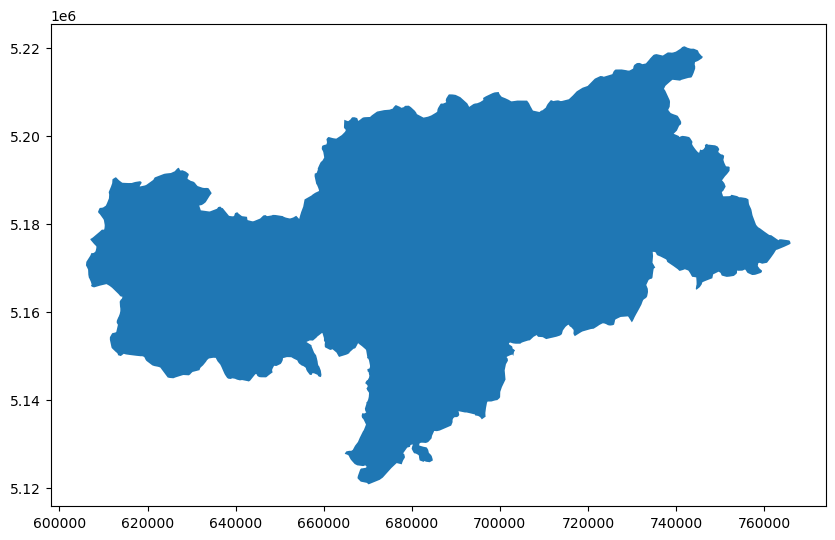

In [157]:
province_of_bolzano.plot(figsize=(10,10))
plt.show()

## 2. load the shapefile of ISTAT with the informations of the muncipalities
### identify the municipalities of the province selected with the biggest and smallest area

this means we need to use another layer / dataset

In [158]:
municipalities = gpd.read_file(url,layer="municipalities")

In [159]:
municipalities.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'PRO_COM',
       'PRO_COM_T', 'COMUNE', 'COMUNE_A', 'CC_UTS', 'geometry'],
      dtype='object')

**COD_RIP**<br/>
*codice ripartizione*<br/>
numeric code of the macroregion of belonging

**COD_REG**<br/>
*codice regione*<br/>
numeric code of the region of belonging

**COD_PROV**<br/>
*codice provincia*<br/>
numeric code of the region of belonging

**COD_CM**<br/>
*codice comune*<br/>
unique numeric identification code of the municipality within the province of belonging

**COD_UTS**<br/>
*codice unità territoriali sovracomunali*<br/>
Numeric code that uniquely identifies the Units
territorial supra-municipal on the national territory.

**PRO_COM**<br/>
*provincia comune**<br/>
Numeric code that uniquely identifies the Municipality
on the national territory. (= COD_PROV & COD_COM) 

**PRO_COM_T**<br/>
*provincia comune territorio**<br/>
Alphanumeric code that uniquely identifies the
Municipality on the national territory.<br/>
Like PRO_COM but definied in 6 fixed characters.

**COMUNE**<br/>
*comune*<br/>
Name of the Municipality

**COMUNE_A**<br/>
*comune alternativa*<br/>
Name of the Municipality in a language other than Italian

**CC_UTS**<br/>
*comune capoluogo*<br/>
Provincial capital or metropolitan city<br/>
1 => True<br/>
2 => False



the **COD_PROV** of the Province of Bolzano is **21**

In [160]:
# filter the province
municipalities_province_bolzano = municipalities[municipalities.COD_PROV==21]

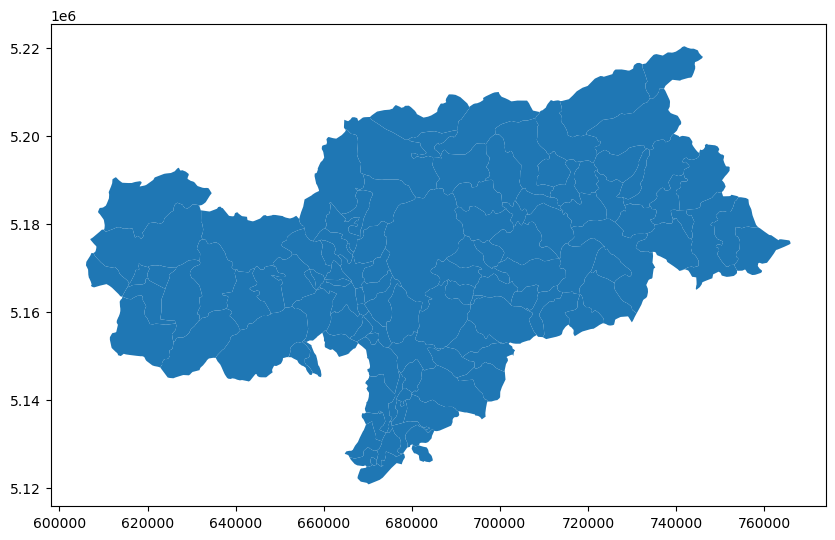

In [161]:
# plot it
municipalities_province_bolzano.plot(figsize=(10,10))
plt.show()

### identify the cities of the province selected with the biggest and smallest area

**CAUTION**:

we are using generalized boundaries !!!

finding the max area

In [162]:
max_area = municipalities_province_bolzano.geometry.area.max()

In [163]:
max_area

301513337.6874822

finding the min area

In [164]:
min_area = municipalities_province_bolzano.geometry.area.min()

In [165]:
min_area

1661458.7378496784

... you can obtain the same in another way (combination of the requests)

In [166]:
municipalities[municipalities.COD_PROV==21].geometry.area.min()

1661458.7378496784

### identify the municipality with the biggest area




In [167]:
maxarea_municipality_southtyrol = municipalities_province_bolzano[municipalities_province_bolzano.geometry.area == max_area]

In [168]:
maxarea_municipality_southtyrol.PRO_COM_T

2871    021086
Name: PRO_COM_T, dtype: object

In [169]:
maxarea_municipality_southtyrol.COMUNE

2871    Sarentino
Name: COMUNE, dtype: object

the municipality with the bigger area is **Sarentino** (021086)

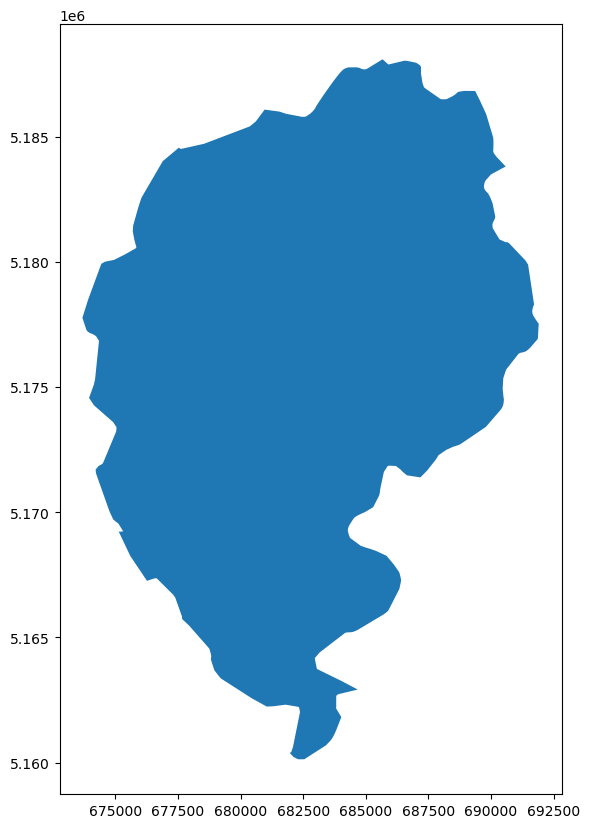

In [170]:
maxarea_municipality_southtyrol.plot(figsize=(10,10))
plt.show()

### identify the municipality with the smallest area


In [171]:
minarea_municipality_southtyrol = municipalities_province_bolzano[municipalities_province_bolzano.geometry.area == min_area]

In [172]:
minarea_municipality_southtyrol.COMUNE

2800    Caines
Name: COMUNE, dtype: object

In [173]:
minarea_municipality_southtyrol.PRO_COM_T

2800    021014
Name: PRO_COM_T, dtype: object

the municipality with the smallest area is **Caines** (021014)

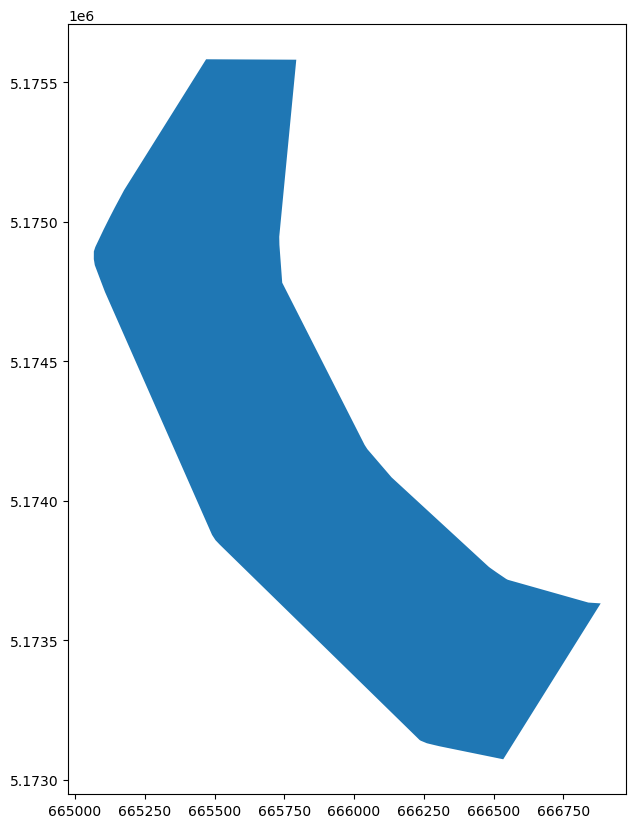

In [174]:
minarea_municipality_southtyrol.plot(figsize=(10,10))
plt.show()

### extract all the centroids of the areas expressed in WGS84

In [175]:
maxarea_municipality_southtyrol.geometry.centroid.to_crs(epsg=4326)

2871    POINT (11.38676 46.71182)
dtype: geometry

In [176]:
maxarea_municipality_southtyrol.geometry.centroid.to_crs(epsg=4326)

2871    POINT (11.38676 46.71182)
dtype: geometry

### extract a rappresenative point for the area of the smallest and bigger municipality in WGS84

In [177]:
representative_point_minarea_municipality = minarea_municipality_southtyrol.geometry.representative_point()

In [178]:
representative_point_maxarea_municipality = maxarea_municipality_southtyrol.geometry.representative_point()

In [179]:
representative_point_minarea_municipality.to_crs(epsg=4326)

2800    POINT (11.16580 46.70333)
dtype: geometry

In [180]:
representative_point_maxarea_municipality.to_crs(epsg=4326)

2871    POINT (11.38521 46.69578)
dtype: geometry

### save the data in GeoJSON files

we can save each point in geojson 

In [181]:
representative_point_maxarea_municipality.to_crs(epsg=4326).to_file("point.geojson",driver="GeoJSON")

... but we need to create an only one file with all the data in a geojson file

In [182]:
points = representative_point_maxarea_municipality.append(representative_point_minarea_municipality)

In [183]:
points.to_crs(epsg=4326).to_file("points.geojson",driver="GeoJSON")

and we can do the same with the polygons

In [184]:
polygons = maxarea_municipality_southtyrol.append(minarea_municipality_southtyrol)

In [185]:
polygons.to_crs(epsg=4326).to_file("polygons.geojson",driver="GeoJSON")

**tip 1**:<br/>
you can download, open with [geojson.io](https://geojson.io) and create a [gist resource](https://gist.github.com/napo/55c1198a8117b4975edc159f2bf98b51#file-largest_smallest_municipality_southtyrol-geojson) to distribute

**tip 2**:<br/>
you can download the files and create a map with [umap](https://umap.openstretmap.fr) and create an [interactive map online with the data](http://u.osmfr.org/m/963189/)

### calculate the distance on the geodentic between the municipality with the big area and smallest area by using the centroid


In [186]:
to_point = minarea_municipality_southtyrol.geometry.centroid.values[0]

In [187]:
maxarea_municipality_southtyrol.geometry.centroid.distance(to_point)

2871    16681.090748
dtype: float64

In [188]:
distance = maxarea_municipality_southtyrol.geometry.centroid.distance(to_point).values[0]

In [189]:
distance

16681.09074818423

the distance is in meters due the CRS used on the dataset 

In [190]:
to_city = minarea_municipality_southtyrol.COMUNE.values[0]
from_city = maxarea_municipality_southtyrol.COMUNE.values[0]
distance_km = distance/1000

In [191]:
print("the distance from %s to %s is %.1f km" % (from_city, to_city, round(distance_km,1)))

the distance from Sarentino to Caines is 16.7 km


### Why a representative point?

Where is the centroid of Liguria?


In [192]:
regions = gpd.read_file(url,layer="regions")

In [193]:
regions.DEN_REG.unique()

array(['Piemonte', "Valle d'Aosta", 'Lombardia', 'Trentino-Alto Adige',
       'Veneto', 'Friuli Venezia Giulia', 'Liguria', 'Emilia-Romagna',
       'Toscana', 'Umbria', 'Marche', 'Lazio', 'Abruzzo', 'Molise',
       'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia',
       'Sardegna'], dtype=object)

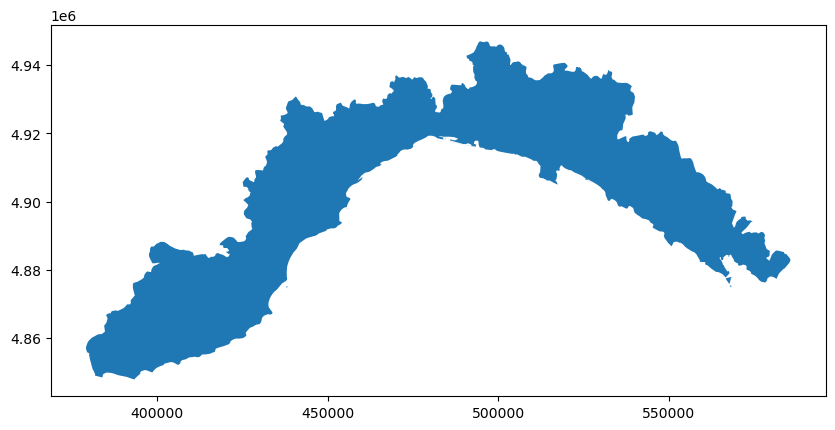

In [194]:
regions[regions.DEN_REG=='Liguria'].plot(figsize=(10,10))
plt.show()

In [195]:
regions[regions.DEN_REG=='Liguria'].to_crs(epsg=4326).to_file("liguria.geojson",driver='GeoJSON')

In [196]:
regions[regions.DEN_REG=='Liguria'].centroid.to_crs(epsg=4326).to_file("liguria_centroid.geojson",driver='GeoJSON')

In [197]:
regions[regions.DEN_REG=='Liguria'].representative_point().to_crs(epsg=4326).to_file("liguria_representative_point.geojson",driver='GeoJSON')

you can upload all the geojson on [uMap](http://umap.openstreetmap.fr) to [see the result](http://umap.openstreetmap.fr/it/map/liguria_505528#8/44.058/9.075) 

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/umap_liguria.jpg)


## 3. download the shapefile of the [Mountain Basins Station](https://media.githubusercontent.com/media/napo/geospatial_datascience_unitn_2023/main/data/idrspacq.zip) of Trentino - projection ETRS89 UTM32N

In [198]:
dataurl='https://media.githubusercontent.com/media/napo/geospatial_datascience_unitn_2023/main/data/idrspacq.zip'
mountain_basins_stations_trentino = gpd.read_file(dataurl)

###  plot the geometries where CODE is "0191" for the table "d_tipouso.dbf"

In [199]:
mountain_basins_stations_trentino.head(3)

,OBJECTID,CLASSID,NOMESPACQ,FKTUSO,PD,FKTGENESI,FKTREGOLAZ,FKTSPECCHI,FKSCALA,DATAINI,DATAFINE,FKFONTE,FKTIPOELAB,FKCODPUB,NOTE,geometry
0,29690.0,E151000000005,LAGO DI MOLVENO,0101,1.0,50,02,01,04,2015-01-16 12:32:45,NaN,03,01,2046,NaN,"POLYGON ((652049.051 5111656.028, 652048.685 5..."
1,29743.0,B05100C002002,LAGO BACINO S.I.T. - BACINO DI PONTARSO,0101,0.0,51,02,01,04,2015-01-16 12:32:47,NaN,03,01,NaN,NaN,"POLYGON ((692800.350 5109936.688, 692800.452 5..."
2,29723.0,A301010601002,LAGO DEL CARESER,0101,1.0,51,02,01,04,2015-01-16 12:32:46,NaN,03,01,1194,NaN,"POLYGON ((630281.891 5142817.705, 630280.968 5..."


where is CODE?

In [200]:
mountain_basins_stations_trentino.columns

Index(['OBJECTID', 'CLASSID', 'NOMESPACQ', 'FKTUSO', 'PD', 'FKTGENESI',
       'FKTREGOLAZ', 'FKTSPECCHI', 'FKSCALA', 'DATAINI', 'DATAFINE', 'FKFONTE',
       'FKTIPOELAB', 'FKCODPUB', 'NOTE', 'geometry'],
      dtype='object')

where is "*CODE*" ???

*We have to analyze the ESRI Shapefile*

In [201]:
os.mkdir("shapefile")

In [202]:
os.chdir("shapefile")

In [203]:
urllib.request.urlretrieve(dataurl ,"idrspacq.zip")


('idrspacq.zip', <http.client.HTTPMessage at 0x7fb731c04950>)

In [204]:
import zipfile
z = zipfile.ZipFile('idrspacq.zip')
z.extractall()

In [205]:
os.listdir()

['idrspacq.shx',
 'idrspacq.zip',
 'idrspacq.dbf',
 'd_tipouso.dbf',
 'idrspacq.shp']

| filenname | description  | note |
|---|---|---|
| idrspacq.shp | the file with the shapes (geometries) | ok |
| d_tipouso.dbf  | the file with the attributes | the name is NOT the same of the .shp |
| idrspacq.dbf | the file with the attributes  | the name is the same of the .shp |
| idrspacq.zip  | the zip archive | it's present because downloaded | 
| idrspacq.shx  | the file to associate the attributes to the geometries | the name is the the of the .shp |

How we can use the file *d_tipouso.dbf*?

Try to create a shapefile from the other

In [206]:
from shutil import copyfile

In [207]:
copyfile("idrspacq.shp","d_tipouso.shp")

'd_tipouso.shp'

In [208]:
copyfile("idrspacq.shx","d_tipouso.shx")

'd_tipouso.shx'

In [209]:
d_tipouso =  gpd.read_file("d_tipouso.shp")

In [210]:
d_tipouso.columns

Index(['CODE', 'NAME', 'DEFINITION', 'ALPHACODE', 'geometry'], dtype='object')

there is the attribute "CODE" ... 

In [211]:
d_tipouso.CODE.unique()

array(['0191', '0102', '0103', '92', '04', '0192', '03', '0101', '02',
       '0193'], dtype=object)

... and there is also the value "02"

In [212]:
code_0191 = d_tipouso[d_tipouso.CODE=='0191']

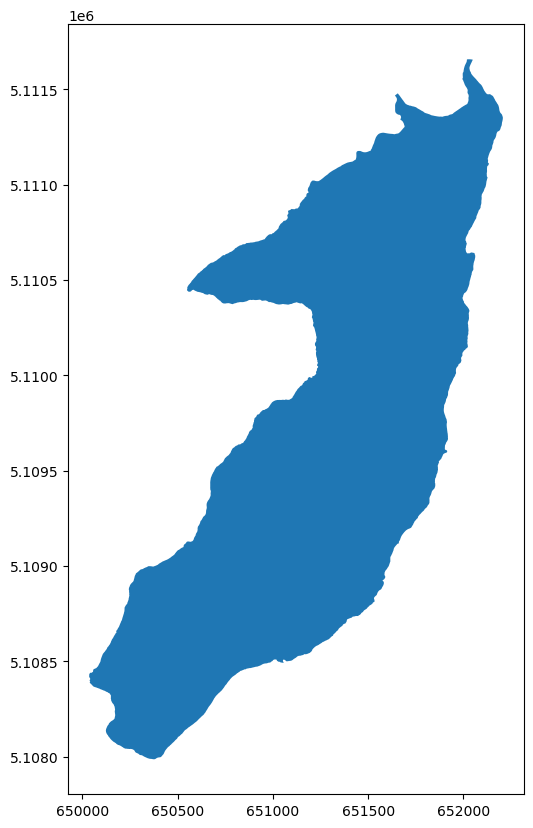

In [213]:
code_0191.plot(figsize=(10,10))
plt.show()

### convert in WGS84 and create a KML and plot it on a website

In [214]:
code_0191.to_crs(epsg=4326)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

ERROR: 
*Cannot transform naive geometries.  Please set a crs on the object first.*

The geodataframe is without the CRS

If you check again all the files contained in the zip archive *the .prj file is not present!!!*

You need to create it!

THe note says "*projection ETRS89 UTM32N(*" 

This is enough to search the right epsg code on https://epsg.io with the query ["ETRS89 UTM 32N1"](https://epsg.io/?q=ETRS89+UTM+32N)


![](https://raw.githubusercontent.com/napo/geospatial_datascience_unitn_2023/main/images/epsg25832.png)


where the EPSG code is 25832


the solution can be possible in two ways:

1 - assign the CRS to the geodataframe


In [ ]:
code_0191.set_crs(epsg=25832,inplace=True,allow_override=True)

,CODE,NAME,DEFINITION,ALPHACODE,geometry
0,0191,innevamento piste,Innevamento piste,0191,"POLYGON ((652049.051 5111656.028, 652048.685 5..."


In [ ]:
code_0191.to_crs(epsg=4326)

,CODE,NAME,DEFINITION,ALPHACODE,geometry
0,0191,innevamento piste,Innevamento piste,0191,"POLYGON ((10.96868 46.14153, 10.96867 46.14152..."


this approach solves the problem but keeps the error in the data source.<br/>
Keeping this approach, it is advisable to apply the assignment of the CRS to the initial geodataframe and, if necessary, to export the geodatrafame in ESRi Shapefile (or other format)

2 - create a file with the name *d_tipouso.prj* that contains the right string in WKT for the proj conversion.

You can obtain the right file by simple download the right string from epsg.io in this way

https://epsg.io/25832.wkt

simple by adding .wkt to the url

this is the answer

``` javascript
PROJCS["ETRS89 / UTM zone 32N",
    GEOGCS["ETRS89",
        DATUM["European_Terrestrial_Reference_System_1989",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6258"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4258"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","25832"]]
```

In [ ]:
url = "https://epsg.io/25832.wkt"
opener = urllib.request.URLopener()
opener.addheader('User-Agent', 'Geospatial Course Unitn')
filename, headers = opener.retrieve(url, 'd_tipouso.prj')

.. it's better create a copy also for the original .shp file

In [ ]:
copyfile("d_tipouso.prj","idrspacq.prj")

'idrspacq.prj'

.. and now it's necessary to recreate the geodataframe and repeat the operations

In [ ]:
d_tipouso = gpd.read_file("d_tipouso.shp")

In [ ]:
d_tipouso.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Now it's ok ;)

In [ ]:
code_0191 = d_tipouso[d_tipouso.CODE=='0191']

... and create the geojson file in wgs84

In [ ]:
code_0191.to_crs(epsg=4326).to_file("code_0191.geojson",driver="GeoJSON")

In [ ]:
fiona.supported_drivers['KML'] = 'rw'

In [ ]:
code_0191.to_crs(epsg=4326).to_file("code_0191.kml",driver="KML")

... and here the lake in Google Earth

![](https://github.com/napo/geospatial_datascience_unitn_2023/blob/main/images/gearth_molveno.png?raw=true)